# **Differentially Private Deep Learning in 20 lines of code**

This is a step-by-step tutorial on how to train a simple PyTorch classification model on MNIST dataset using a differentially private - stochastic gradient descent optimizer in 20 lines of code using the PyTorch opacus library.  

Link to blogpost: https://blog.openmined.org/differentially-private-deep-learning-using-opacus-in-20-lines-of-code/

Link to library: https://github.com/pytorch/opacus

Author: Kritika Prakash, OpenMined


### **Step 1: Importing PyTorch and Opacus**

In [9]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
from opacus import PrivacyEngine
from tqdm import tqdm

In [56]:
# !pip install -e .

## **Step 2: Loading MNIST data**

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../mnist',
                   train=True,
                   download=True,
                   transform=transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize((0.1307,), (0.3081,)),]),),
                   batch_size=64,
                   shuffle=True,
                   num_workers=1,
                   pin_memory=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../mnist', 
                       train=False, 
                       transform=transforms.Compose([transforms.ToTensor(), 
                                                     transforms.Normalize((0.1307,), (0.3081,)),]),), 
                       batch_size=1024,
                       shuffle=True,
                       num_workers=1,
                       pin_memory=True)

## **Step 3: Creating a Neural Network Classification Model and Optimizer**

In [3]:
model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 16, 8, 2, padding=3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2, 1),
        torch.nn.Conv2d(16, 32, 4, 2),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2, 1),
        torch.nn.Flatten(),
        torch.nn.Linear(32 * 4 * 4, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 10))

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

## **Step 4: Creating and Attaching a Differential Privacy Engine to the Optimizer**

In [4]:
privacy_engine = PrivacyEngine(
    model,
    batch_size=64,
    sample_size=60000,
    alphas=range(2,32),
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)

privacy_engine.attach(optimizer)

/home/rosa/opacus-master/opacus/privacy_engine.py:104: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


## **Step 5: Creating a training function**

In [5]:
def train(model, train_loader, optimizer, epoch, device, delta):
    model.train()
    criterion = nn.CrossEntropyLoss()
    losses = []
    for _batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    
    epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(delta)
    print(
        f"Train Epoch: {epoch} \t"
        f"Loss: {np.mean(losses):.6f} "
        f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}"
    )

## **Step 6: Training the private model over multiple epochs**

In [6]:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch, device="cpu", delta=1e-5)

100%|█████████▉| 937/938 [00:17<00:00, 61.35it/s]/home/rosa/opacus-master/opacus/privacy_engine.py:280: UserWarning: PrivacyEngine expected a batch of size 64 but the last step received a batch of size 32. This means that the privacy analysis will be a bit more pessimistic. You can set `drop_last = True` in your PyTorch dataloader to avoid this problem completely
  f"PrivacyEngine expected a batch of size {self.batch_size} "
  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 	Loss: 1.335555 (ε = 0.55, δ = 1e-05) for α = 23


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 2 	Loss: 0.609898 (ε = 0.57, δ = 1e-05) for α = 22


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 3 	Loss: 0.552978 (ε = 0.58, δ = 1e-05) for α = 22


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 4 	Loss: 0.510128 (ε = 0.59, δ = 1e-05) for α = 22


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 5 	Loss: 0.482147 (ε = 0.60, δ = 1e-05) for α = 22


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 6 	Loss: 0.466153 (ε = 0.61, δ = 1e-05) for α = 22


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 7 	Loss: 0.478283 (ε = 0.62, δ = 1e-05) for α = 22


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 8 	Loss: 0.469972 (ε = 0.63, δ = 1e-05) for α = 22


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 9 	Loss: 0.463410 (ε = 0.64, δ = 1e-05) for α = 22


100%|██████████| 938/938 [00:15<00:00, 61.51it/s]

Train Epoch: 10 	Loss: 0.486159 (ε = 0.65, δ = 1e-05) for α = 22


In [7]:
import matplotlib.pyplot as plt
epoch = [*range(1,11,1)]
epsilon = [0.55, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65]
loss = [1.162757, 0.595237, 0.579614, 0.522272, 0.507108, 0.526577, 0.530179, 0.528997, 0.525267, 0.540919]

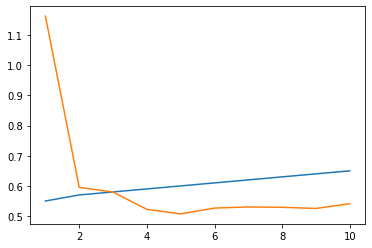

In [10]:
plt.plot(epoch, epsilon, label="epsilon")
plt.plot(epoch, loss)

## **Putting the code all together**

In [9]:
# Step 1: Importing PyTorch and Opacus
import torch
from torchvision import datasets, transforms
import numpy as np
from opacus import PrivacyEngine
from tqdm import tqdm

# Step 2: Loading MNIST Data
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist', train=True, download=True,
               transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), 
               (0.3081,)),]),), batch_size=64, shuffle=True, num_workers=1, pin_memory=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist', train=False, 
              transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), 
              (0.3081,)),]),), batch_size=1024, shuffle=True, num_workers=1, pin_memory=True)

# Step 3: Creating a PyTorch Neural Network Classification Model and Optimizer
model = torch.nn.Sequential(torch.nn.Conv2d(1, 16, 8, 2, padding=3), torch.nn.ReLU(), torch.nn.MaxPool2d(2, 1),
        torch.nn.Conv2d(16, 32, 4, 2),  torch.nn.ReLU(), torch.nn.MaxPool2d(2, 1), torch.nn.Flatten(), 
        torch.nn.Linear(32 * 4 * 4, 32), torch.nn.ReLU(), torch.nn.Linear(32, 10))

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

# Step 4: Attaching a Differential Privacy Engine to the Optimizer
privacy_engine = PrivacyEngine(model, batch_size=64, sample_size=60000, alphas=range(2,32), 
                               noise_multiplier=1.3, max_grad_norm=1.0,)

privacy_engine.attach(optimizer)

# Step 5: Training the private model over multiple epochs
def train(model, train_loader, optimizer, epoch, device, delta):
    
    model.train()
    criterion = nn.CrossEntropyLoss()
    losses = []
    
    for _batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(delta)
    
    print(
        f"Train Epoch: {epoch} \t"
        f"Loss: {np.mean(losses):.6f} "
        f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}"
    )
    
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch, device="cpu", delta=1e-5)

/home/rosa/opacus-master/opacus/privacy_engine.py:104: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
100%|█████████▉| 937/938 [00:10<00:00, 89.74it/s]/home/rosa/opacus-master/opacus/privacy_engine.py:280: UserWarning: PrivacyEngine expected a batch of size 64 but the last step received a batch of size 32. This means that the privacy analysis will be a bit more pessimistic. You can set `drop_last = True` in your PyTorch dataloader to avoid this problem completely
  f"PrivacyEngine expected a batch of size {self.batch_size} "
  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 	Loss: 1.183973 (ε = 0.55, δ = 1e-05) for α = 23


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 2 	Loss: 0.514143 (ε = 0.57, δ = 1e-05) for α = 22


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 3 	Loss: 0.468444 (ε = 0.58, δ = 1e-05) for α = 22


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 4 	Loss: 0.483729 (ε = 0.59, δ = 1e-05) for α = 22


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 5 	Loss: 0.459814 (ε = 0.60, δ = 1e-05) for α = 22


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 6 	Loss: 0.462071 (ε = 0.61, δ = 1e-05) for α = 22


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 7 	Loss: 0.491132 (ε = 0.62, δ = 1e-05) for α = 22


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 8 	Loss: 0.495203 (ε = 0.63, δ = 1e-05) for α = 22


  0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 9 	Loss: 0.526300 (ε = 0.64, δ = 1e-05) for α = 22


100%|██████████| 938/938 [00:10<00:00, 87.36it/s]

Train Epoch: 10 	Loss: 0.531549 (ε = 0.65, δ = 1e-05) for α = 22
